# OPS-SAT case starter-kit notebook

ESA's [Kelvins](https://kelvins.esa.int) competition "[the OPS-SAT case](https://kelvins.esa.int/opssat/home/)" is a novel data-centric challenge that asks you to work with the raw data of a satellite and very few provided labels to find the best parameters for a given machine learning model. Compared to previous competitions on Kelvins (like the [Pose Estimation](https://kelvins.esa.int/pose-estimation-2021/) or the [Proba-V Super-resolution challenge](https://kelvins.esa.int/proba-v-super-resolution/)) where the test-set is provided and the infered results are submitted, for the OPS-SAT case, we will run inference on the Kelvins server directly! This notebooks contains examples on how you can load your data and train an **EfficientNetLite0** model by only using the 80-labeled images provided. Therefore, the directory `images`, containing unlabeld patches and included in the training dataset is not used for this notebook. However, competitors are encouraged to use these patches to improve the model accuracy.

# 1. Module imports

If you do not have a GPU, uncomment and run the next commands.


In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

Other imports.

In [2]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
from sklearn.metrics import cohen_kappa_score

from efficientnet_lite import EfficientNetLiteB0

import matplotlib.pyplot as plt
from sklearn import metrics

# 2. Utility Functions

You can use this function to load your training data.

In [3]:
def get_images_from_path(dataset_path):
    """ Get images from path and normalize them applying channel-level normalization. """

    # loading all images in one large batch
    # shuffle images and labels and set seed
    tf_eval_data = tf.keras.utils.image_dataset_from_directory(dataset_path, batch_size=100000, image_size=input_shape[:2], shuffle=True, seed=42)

    # extract images and targets
    for tf_eval_images, tf_eval_targets in tf_eval_data:
        break

    return tf.convert_to_tensor(tf_eval_images), tf_eval_targets

In [4]:
class_mapping = {0: 'Agriculture',
                 1: 'Cloud',
                 2: 'Mountain',
                 3: 'Natural',
                 4: 'River',
                 5: 'Sea_ice',
                 6: 'Snow',
                 7: 'Water'}

In [5]:
def visualize_image(features, labels, image, pred=False, **kwargs):
    plt.imshow(features[image].numpy().astype(int))
    print('Class: {}'.format(class_mapping[labels[image].numpy()]))
    if pred:
        predictions = kwargs.get('predictions', None)
        print('Predicted: {}'.format(class_mapping[predictions[image]]))
    plt.show()    

In [6]:
def evaluate_model(features, labels):
    
    predictions = np.zeros(len(labels), dtype=np.int8)
    
    for e, (image, target) in enumerate(zip(features, labels)):
        image = np.expand_dims(np.array(image), axis=0)
        output = model.predict(image)
        predictions[e] = np.squeeze(output).argmax()
    
    score_keras = 1 - cohen_kappa_score(labels.numpy(), predictions)
    print("Score:",score_keras)
    
    return predictions

In [7]:
def get_confusion_matrix(actual, predicted):
    
    actual = actual.numpy()
    predicted = predicted
    
    metrics.ConfusionMatrixDisplay.from_predictions(actual, predicted, display_labels = list(class_mapping.values()), xticks_rotation='vertical')
    
    plt.show()

# 3. Loading the model

The network architecture used for OPS-SAT is **EfficientNetLite0**. We would like to thank Sebastian for making a Keras implementation of EfficientNetLite publicly available under the Apache 2.0 License: https://github.com/sebastian-sz/efficientnet-lite-keras. Our Version of this code has been modified to better fit our purposes. For example, we removed the ReLU "stem_activation" to better match a related efficientnet pytorch implementation. In any way, **you have to use the model architecture that we provide in our [starter-kit](https://gitlab.com/EuropeanSpaceAgency/the_opssat_case_starter_kit).**

In [8]:
input_shape = (200, 200, 3)   # input_shape is (height, width, number of channels) for images
num_classes = 8
model = EfficientNetLiteB0(classes=num_classes, weights=None, input_shape=input_shape, classifier_activation=None)
model.summary()

block1a_ same
block2a_ ((1, 1), (1, 1))
block2a_ valid
block2b_ same
block3a_ ((2, 2), (2, 2))
block3a_ valid
block3b_ same
block4a_ ((1, 1), (1, 1))
block4a_ valid
block4b_ same
block4c_ same
block5a_ same
block5b_ same
block5c_ same
block6a_ ((2, 2), (2, 2))
block6a_ valid
block6b_ same
block6c_ same
block6d_ same
block7a_ same
Model: "efficientnetlite0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 201, 201, 3)  0           ['input_1[0][0]']                
                                               

# 4. Loading data

Uncomment next line and adjust with the path of your dataset. 

In [9]:
dataset_path="../ops_sat_competiton_official"

In this notebook, classical supervised learning is used. Therefore, remember to remove the subdirectory `images` containing unlabeled patches before loading the dataset to perform training correctly.

In [10]:
#Loading dataset
x_train, y_train = get_images_from_path(dataset_path)

Found 80 files belonging to 8 classes.


In [11]:
x_train.shape

TensorShape([80, 200, 200, 3])

In [12]:
y_train.shape

TensorShape([80])

In [13]:
y_train

<tf.Tensor: shape=(80,), dtype=int32, numpy=
array([6, 3, 5, 0, 2, 0, 2, 6, 0, 7, 4, 1, 1, 0, 3, 7, 3, 7, 2, 1, 1, 5,
       7, 6, 0, 5, 5, 6, 1, 2, 4, 6, 7, 7, 1, 3, 2, 5, 5, 4, 4, 6, 3, 0,
       4, 2, 1, 3, 6, 0, 3, 3, 0, 6, 6, 1, 4, 4, 7, 7, 5, 2, 2, 6, 2, 3,
       0, 7, 4, 3, 5, 0, 4, 5, 2, 4, 1, 7, 5, 1])>

### Train val test split

In [14]:
x_test = x_train[:20]
y_test = y_train[:20]
print(x_test.shape, y_test.shape)

(20, 200, 200, 3) (20,)


In [15]:
for i in np.arange(num_classes):
    print('Class: {}; Occurrences: {}'.format(i, np.count_nonzero(y_test == i)))

Class: 0; Occurrences: 4
Class: 1; Occurrences: 3
Class: 2; Occurrences: 3
Class: 3; Occurrences: 3
Class: 4; Occurrences: 1
Class: 5; Occurrences: 1
Class: 6; Occurrences: 2
Class: 7; Occurrences: 3


Class: Agriculture


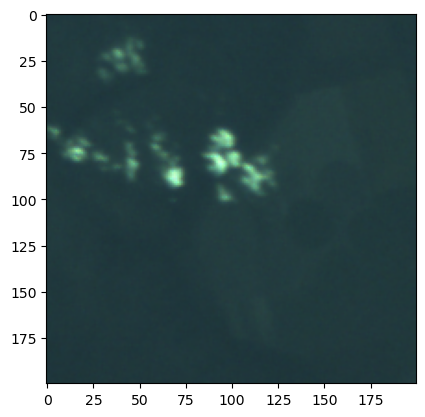

In [16]:
visualize_image(x_test, y_test, 5)

In [17]:
x_val = x_train[20:40]
y_val = y_train[20:40]
print(x_val.shape, y_val.shape)

(20, 200, 200, 3) (20,)


In [18]:
for i in np.arange(num_classes):
    print('Class: {}; Occurrences: {}'.format(i, np.count_nonzero(y_val == i)))

Class: 0; Occurrences: 1
Class: 1; Occurrences: 3
Class: 2; Occurrences: 2
Class: 3; Occurrences: 1
Class: 4; Occurrences: 2
Class: 5; Occurrences: 5
Class: 6; Occurrences: 3
Class: 7; Occurrences: 3


Class: Sea_ice


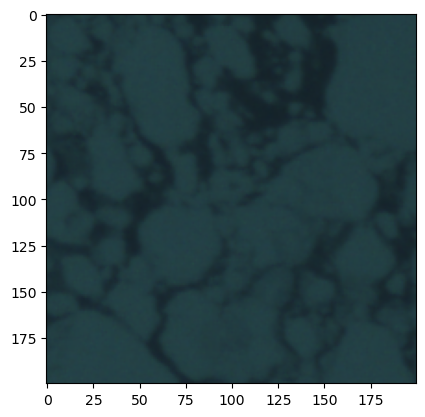

In [19]:
visualize_image(x_val, y_val, 5)

In [20]:
x_train = x_train[40:]
y_train = y_train[40:]
print(x_train.shape, y_train.shape)

(40, 200, 200, 3) (40,)


In [21]:
for i in np.arange(num_classes):
    print('Class: {}; Occurrences: {}'.format(i, np.count_nonzero(y_train == i)))

Class: 0; Occurrences: 5
Class: 1; Occurrences: 4
Class: 2; Occurrences: 5
Class: 3; Occurrences: 6
Class: 4; Occurrences: 7
Class: 5; Occurrences: 4
Class: 6; Occurrences: 5
Class: 7; Occurrences: 4


Class: Mountain


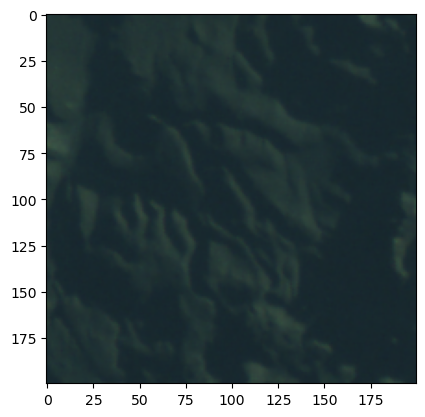

In [22]:
visualize_image(x_train, y_train, 5)

### Augment images

#### Rotate images

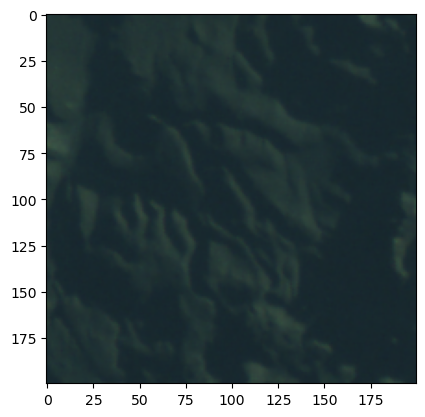

In [23]:
plt.imshow(x_train[5].numpy().astype(int))

90 degrees counterclockwise

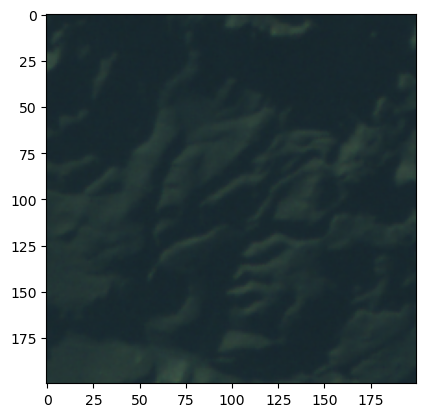

In [24]:
plt.imshow(np.rot90(x_train[5].numpy().astype(int), k=1, axes=(0, 1)))

In [25]:
x_train_rot90_ccw = np.rot90(x_train.numpy().astype(int), axes=(1,2))

In [26]:
x_train_rot90_ccw.shape

(40, 200, 200, 3)

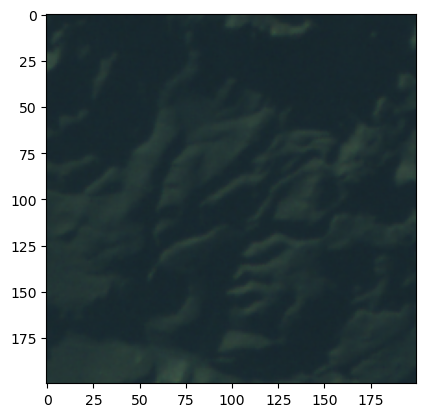

In [27]:
plt.imshow(x_train_rot90_ccw[5])

In [28]:
x_train_augmented = tf.convert_to_tensor(np.vstack([x_train.numpy(), x_train_rot90_ccw]))
x_train_augmented.shape

TensorShape([80, 200, 200, 3])

In [29]:
y_train_augmented = tf.convert_to_tensor(np.concatenate([y_train.numpy(), y_train.numpy()]), dtype=np.int32)
y_train_augmented.shape

TensorShape([80])

180 degrees

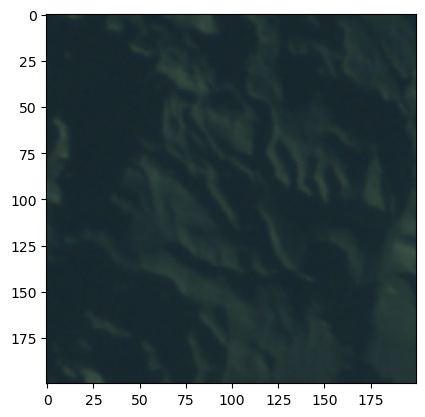

In [30]:
plt.imshow(np.rot90(np.rot90(x_train[5].numpy().astype(int), k=1, axes=(0, 1)), k=1, axes=(0, 1)))

In [31]:
x_train_rot180 = np.rot90(np.rot90(x_train.numpy().astype(int), axes=(1,2)), axes=(1,2))

In [32]:
x_train_rot180.shape

(40, 200, 200, 3)

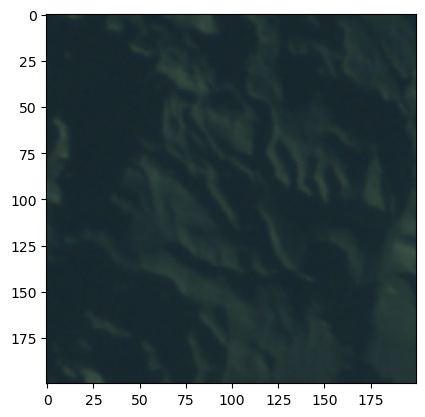

In [33]:
plt.imshow(x_train_rot180[5])

In [34]:
x_train_augmented = tf.convert_to_tensor(np.vstack([x_train_augmented.numpy(), x_train_rot180]))
x_train_augmented.shape

TensorShape([120, 200, 200, 3])

In [35]:
y_train_augmented = tf.convert_to_tensor(np.concatenate([y_train_augmented.numpy(), y_train.numpy()]), dtype=np.int32)
y_train_augmented.shape

TensorShape([120])

90 degrees clockwise

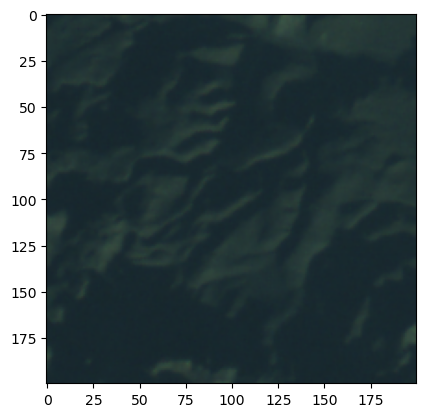

In [36]:
plt.imshow(np.rot90(x_train[5].numpy().astype(int), k=-1, axes=(0, 1)))

In [37]:
x_train_rot90_cw = np.rot90(x_train.numpy().astype(int), axes=(2,1))

In [38]:
x_train_rot90_cw.shape

(40, 200, 200, 3)

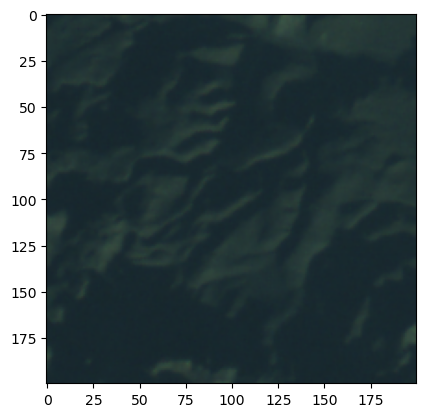

In [39]:
plt.imshow(x_train_rot90_cw[5])

In [40]:
x_train_augmented = tf.convert_to_tensor(np.vstack([x_train_augmented.numpy(), x_train_rot90_cw]))
x_train_augmented.shape

TensorShape([160, 200, 200, 3])

In [41]:
y_train_augmented = tf.convert_to_tensor(np.concatenate([y_train_augmented.numpy(), y_train.numpy()]), dtype=np.int32)
y_train_augmented.shape

TensorShape([160])

#### Flip images

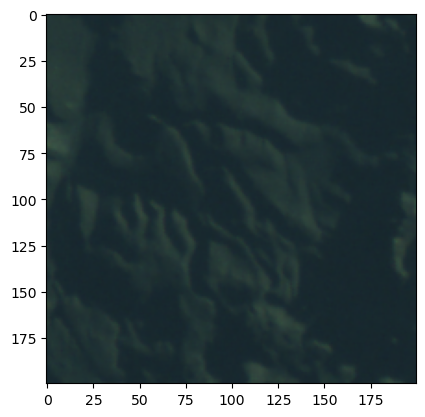

In [42]:
plt.imshow(x_train[5].numpy().astype(int))

Up/down

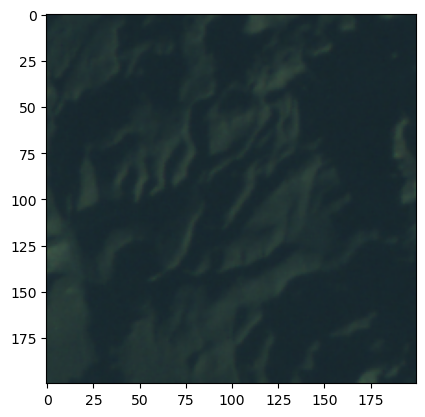

In [43]:
plt.imshow(np.flipud(x_train[5].numpy().astype(int)))

In [44]:
x_train_flipud = np.array([np.flipud(i.numpy().astype(int)) for i in x_train])

In [45]:
x_train_flipud.shape

(40, 200, 200, 3)

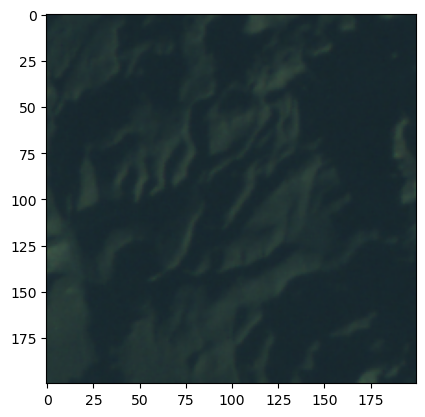

In [46]:
plt.imshow(x_train_flipud[5])

In [47]:
x_train_augmented = tf.convert_to_tensor(np.vstack([x_train_augmented.numpy(), x_train_flipud]))
x_train_augmented.shape

TensorShape([200, 200, 200, 3])

In [48]:
y_train_augmented = tf.convert_to_tensor(np.concatenate([y_train_augmented.numpy(), y_train.numpy()]), dtype=np.int32)
y_train_augmented.shape

TensorShape([200])

Left/right

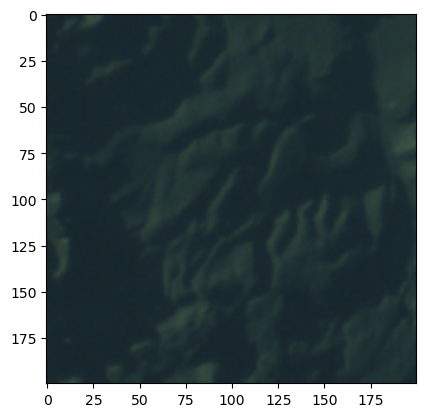

In [49]:
plt.imshow(np.fliplr(x_train[5].numpy().astype(int)))

In [50]:
x_train_fliplr = np.array([np.fliplr(i.numpy().astype(int)) for i in x_train])

In [51]:
x_train_fliplr.shape

(40, 200, 200, 3)

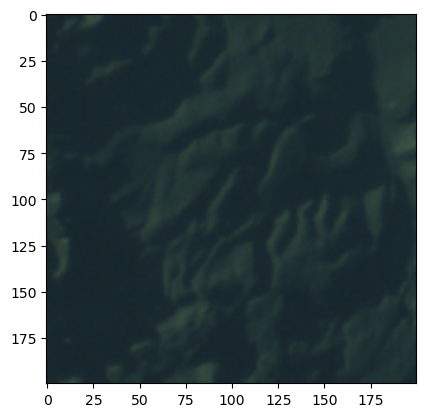

In [52]:
plt.imshow(x_train_fliplr[5])

In [53]:
x_train_augmented = tf.convert_to_tensor(np.vstack([x_train_augmented.numpy(), x_train_fliplr]))
x_train_augmented.shape

TensorShape([240, 200, 200, 3])

In [54]:
y_train_augmented = tf.convert_to_tensor(np.concatenate([y_train_augmented.numpy(), y_train.numpy()]), dtype=np.int32)
y_train_augmented.shape

TensorShape([240])

#### Flip rotated images up/down

Skip the following variations since these images already exist:

- rot180 ud
- rot90 ccw lr
- rot90 cw lr

90 degrees counterclockwise up/down

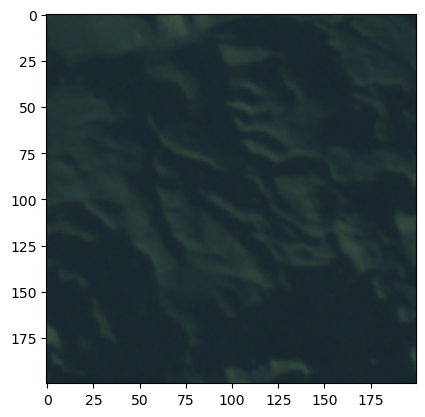

In [55]:
plt.imshow(np.flipud(x_train_rot90_ccw[5]))

In [56]:
x_train_rot90_ccw_flipud = np.array([np.flipud(i) for i in x_train_rot90_ccw])

In [57]:
x_train_rot90_ccw_flipud.shape

(40, 200, 200, 3)

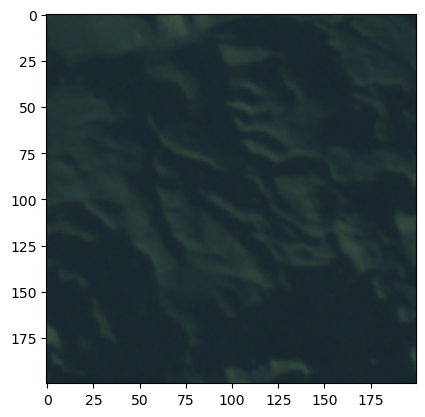

In [58]:
plt.imshow(x_train_rot90_ccw_flipud[5])

In [59]:
x_train_augmented = tf.convert_to_tensor(np.vstack([x_train_augmented.numpy(), x_train_rot90_ccw_flipud]))
x_train_augmented.shape

TensorShape([280, 200, 200, 3])

In [60]:
y_train_augmented = tf.convert_to_tensor(np.concatenate([y_train_augmented.numpy(), y_train.numpy()]), dtype=np.int32)
y_train_augmented.shape

TensorShape([280])

90 degrees clockwise up/down

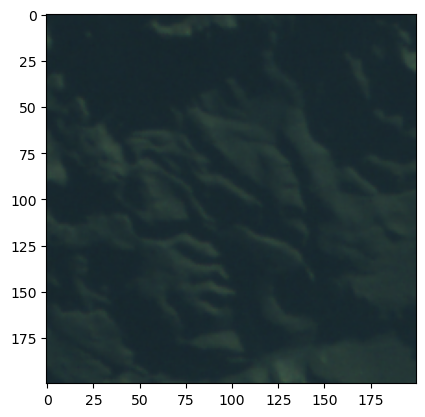

In [61]:
plt.imshow(np.flipud(x_train_rot90_cw[5]))

In [62]:
x_train_rot90_cw_flipud = np.array([np.flipud(i) for i in x_train_rot90_cw])

In [63]:
x_train_rot90_cw_flipud.shape

(40, 200, 200, 3)

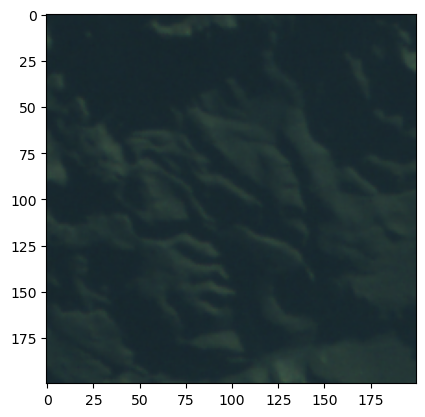

In [64]:
plt.imshow(x_train_rot90_cw_flipud[5])

In [65]:
x_train_augmented = tf.convert_to_tensor(np.vstack([x_train_augmented.numpy(), x_train_rot90_cw_flipud]))
x_train_augmented.shape

TensorShape([320, 200, 200, 3])

In [66]:
y_train_augmented = tf.convert_to_tensor(np.concatenate([y_train_augmented.numpy(), y_train.numpy()]), dtype=np.int32)
y_train_augmented.shape

TensorShape([320])

# 5. Model training

We provide now an example on how you can train your model by using standard supervised learning. Training loss (`SparseCategoricalCrossentropy`) and `Accuracy` are shown for simplicity and for an easier interpretation of the training outcome, despite your submission will be evaluated by using the metric **1 - Cohen's kappa** [metric](https://en.wikipedia.org/wiki/Cohen's_kappa). For more information on scoring, please refer to [Scoring](https://kelvins.esa.int/opssat/scoring/).

In [69]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[keras.metrics.SparseCategoricalAccuracy()])

With this model and the dataset provided, please do your best!

In [70]:
tf.random.set_seed(42)

In [71]:
%%time
# load data, data augmentation, training, overfitting, transfer-learning etc.
history=model.fit(x_train_augmented, y_train_augmented, epochs=55, verbose=1, batch_size=8, validation_data=(x_val, y_val))

Epoch 1/55
40/40 [==============================] - 34s 772ms/step - loss: 4.4925 - sparse_categorical_accuracy: 0.1937 - val_loss: 16.2142 - val_sparse_categorical_accuracy: 0.2000
Epoch 2/55
40/40 [==============================] - 30s 747ms/step - loss: 3.9499 - sparse_categorical_accuracy: 0.2156 - val_loss: 7.1542 - val_sparse_categorical_accuracy: 0.2000
Epoch 3/55
40/40 [==============================] - 29s 719ms/step - loss: 3.1375 - sparse_categorical_accuracy: 0.2562 - val_loss: 10.7786 - val_sparse_categorical_accuracy: 0.0500
Epoch 4/55
40/40 [==============================] - 30s 755ms/step - loss: 3.0118 - sparse_categorical_accuracy: 0.2313 - val_loss: 9.7129 - val_sparse_categorical_accuracy: 0.0500
Epoch 5/55
40/40 [==============================] - 30s 753ms/step - loss: 2.4732 - sparse_categorical_accuracy: 0.3063 - val_loss: 7.9767 - val_sparse_categorical_accuracy: 0.1000
Epoch 6/55
40/40 [==============================] - 28s 711ms/step - loss: 2.6753 - sparse_ca

### Plot loss and accuracy

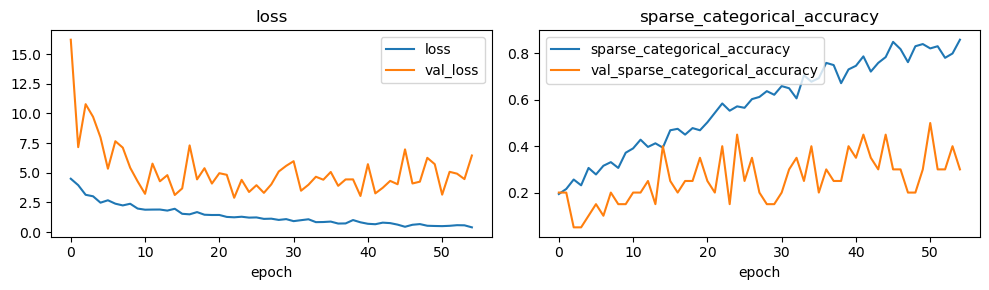

In [72]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 3))

ax0.plot(history.history['loss'], label='loss')
ax0.plot(history.history['val_loss'], label='val_loss')
ax0.set_title('loss')
ax0.set_xlabel('epoch')
ax0.legend()

ax1.plot(history.history['sparse_categorical_accuracy'], label='sparse_categorical_accuracy')
ax1.plot(history.history['val_sparse_categorical_accuracy'], label='val_sparse_categorical_accuracy')
ax1.set_title('sparse_categorical_accuracy')
ax1.set_xlabel('epoch')
ax1.legend()

plt.tight_layout()           
plt.show()

Calculating the **1 - Cohen's kappa** score of the trained model on the trained dataset.

In [73]:
predictions = evaluate_model(x_train_augmented, y_train_augmented)

Score: 0.3588087549336203


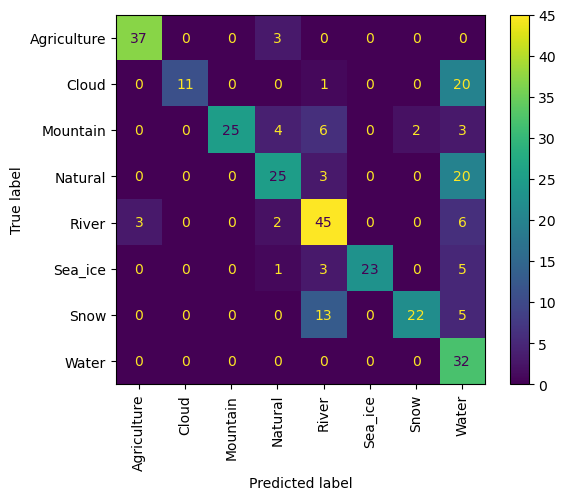

In [74]:
get_confusion_matrix(y_train_augmented, predictions)

Class: Mountain
Predicted: Mountain


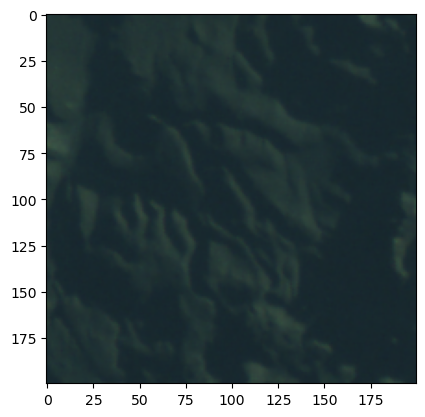

In [75]:
visualize_image(x_train_augmented, y_train_augmented, 5, pred=True, predictions=predictions)

### Evaluation on val set

In [76]:
predictions = evaluate_model(x_val, y_val)

Score: 0.8163265306122449


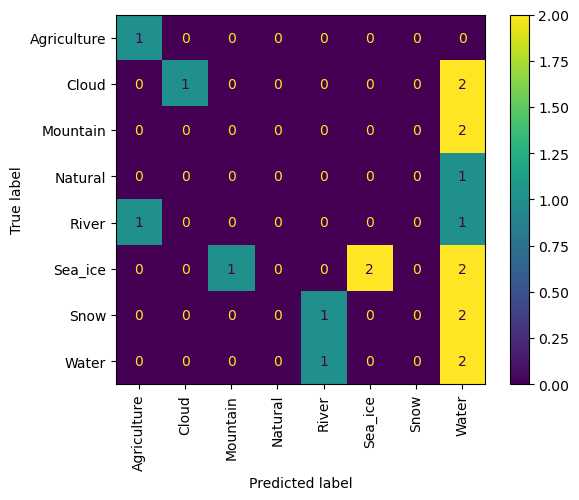

In [77]:
get_confusion_matrix(y_val, predictions)

Class: Sea_ice
Predicted: Sea_ice


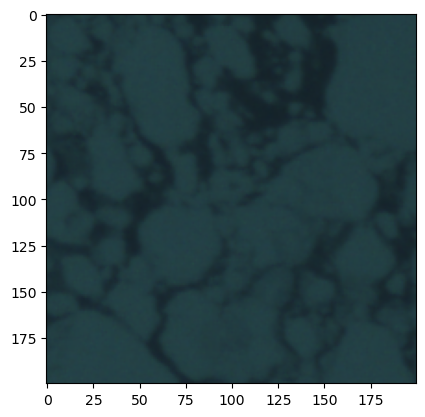

In [78]:
visualize_image(x_val, y_val, 5, pred=True, predictions=predictions)

### Evaluation on test set

In [79]:
predictions = evaluate_model(x_test, y_test)

Score: 0.8620689655172414


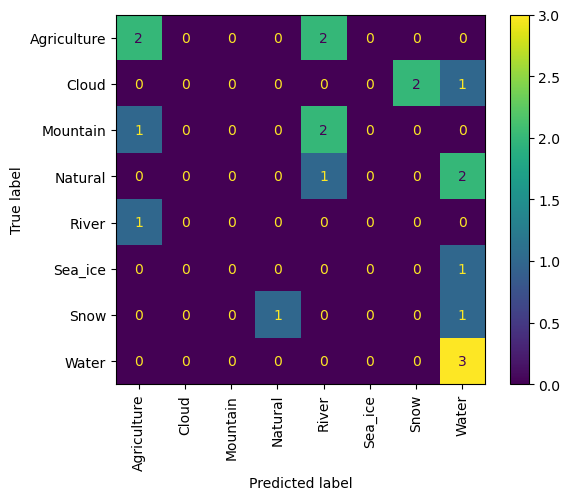

In [80]:
get_confusion_matrix(y_test, predictions)

Class: Agriculture
Predicted: River


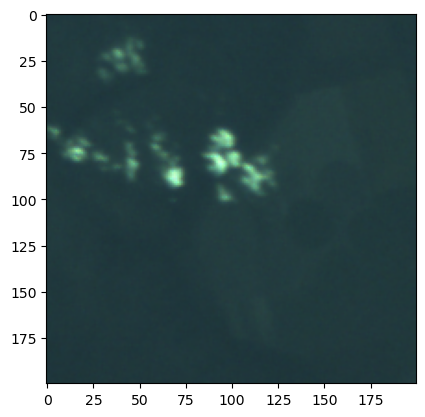

In [81]:
visualize_image(x_test, y_test, 5, pred=True, predictions=predictions)

# 6. Saving and loading trained model

The trained model can be now saved by using HDF5-format that is the only accepted for submission. The name `test.h5` will be used.

In [82]:
#Saving model
model.save_weights('v3.h5')

The trained model can be also loaded for further testing. 

In [83]:
model = EfficientNetLiteB0(classes=num_classes, weights=None, input_shape=input_shape, classifier_activation=None)
model.load_weights('v3.h5')

block1a_ same
block2a_ ((1, 1), (1, 1))
block2a_ valid
block2b_ same
block3a_ ((2, 2), (2, 2))
block3a_ valid
block3b_ same
block4a_ ((1, 1), (1, 1))
block4a_ valid
block4b_ same
block4c_ same
block5a_ same
block5b_ same
block5c_ same
block6a_ ((2, 2), (2, 2))
block6a_ valid
block6b_ same
block6c_ same
block6d_ same
block7a_ same


The model will be now compiled and tested again. You should get the same score as before saving and loading. 

In [84]:
#Model shall be compiled before testing.
model.compile()

#Creating empty predictions
predictions = np.zeros(len(y_train_augmented), dtype=np.int8)

# inference loop
for e, (image, target) in enumerate(zip(x_train_augmented, y_train_augmented)):
    image = np.expand_dims(np.array(image), axis=0)
    output = model.predict(image)
    predictions[e] = np.squeeze(output).argmax()

#Keras model score
score_keras = 1 - cohen_kappa_score(y_train_augmented.numpy(), predictions)
print("Score:",score_keras)

Score: 0.3588087549336203
